# Assignment 4 - Part 2
## by Viy Moodley (300565283)


In [1]:
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
train_data =  pd.read_csv("/Users/viyankamoodley/Desktop/301/Assignment 4/train-1.csv")
test_data = pd.read_csv("/Users/viyankamoodley/Desktop/301/Assignment 4/test-1.csv" )

In [3]:
train_data.head()

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,date_of_occupancy,number_of_windows,geo_code,claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          6117 non-null   object 
 1   year_of_observation  6117 non-null   int64  
 2   insured_period       6117 non-null   float64
 3   residential          6117 non-null   int64  
 4   building_painted     6117 non-null   object 
 5   building_fenced      6117 non-null   object 
 6   garden               6110 non-null   object 
 7   settlement           6117 non-null   object 
 8   building_dimension   6015 non-null   float64
 9   building_type        6117 non-null   int64  
 10  date_of_occupancy    5658 non-null   float64
 11  number_of_windows    6117 non-null   object 
 12  geo_code             6019 non-null   object 
 13  claim                6117 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 669.2+ KB


There are 6117 entries of data and there are 14 columns representing a feature. There are 7 'categorical' features given by the object data types, and 7 numeric - three of which are floating points and 4 are integers. Our target feature is 'claim'. On first glance, I see that the number of windows is marked as an 'object' which doesn't make sense given it represents a measurable value...

In [5]:
train_data.describe()

,year_of_observation,insured_period,residential,building_dimension,building_type,date_of_occupancy,claim
count,6117.000000,6117.000000,6117.000000,6015.000000,6117.000000,5658.000000,6117.000000
mean,2013.272192,0.906808,0.309956,1879.536326,2.190289,1964.894662,0.231976
std,1.075760,0.243628,0.462513,2268.133418,0.938294,35.118585,0.422129
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,1.000000,0.000000,520.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1084.000000,2.000000,1970.000000,0.000000
75%,2014.000000,1.000000,1.000000,2288.500000,3.000000,1980.000000,0.000000
max,2015.000000,1.000000,1.000000,20940.000000,4.000000,2015.000000,1.000000


- Data seems to be collected over a three year range, from 2012 to 2015 - as indicated by '*year_of_observation*'
- The insured_period column has a minimum value of 0 and a maximum value of 1, but its 25%, 50% and 75% quantiles are all represented as 1... The data description says it represents the duration of a policy, with 1 as the longest duration, a full year. I will check its value counts.
- building_dimension is highly skewed, there's indication of extreme outliers. it's 75%th percentile is almost 10 times smaller than its max value.
- data_of_occupancy starts quite early at 1545, which appears to be an outlier based on the 25% percentile being around 1960. 

In [6]:
train_data['building_painted'].value_counts()

building_painted
V    4566
N    1551
Name: count, dtype: int64

Majority of buildings in this dataset are not painted

In [7]:
train_data['residential'].value_counts()

residential
0    4221
1    1896
Name: count, dtype: int64

It appears that this is a minority class, with the majority of the buildings not being residential... This makes me wonder whether things like fencing, paint and settlement are important factors...

In [8]:
corr_matrix = train_data.corr(numeric_only=True)

In [9]:
corr_matrix["claim"].sort_values(ascending=False)

claim                  1.000000
building_dimension     0.298694
building_type          0.107735
insured_period         0.089251
residential            0.061279
date_of_occupancy      0.022579
year_of_observation   -0.001887
Name: claim, dtype: float64

A building's dimension, it's type, the duration of its insured period as well as the residential feature are the most highly correlated with whether or not a claim is made. The year of observation is not that important, so I will remove it in preprocessing. 

In [10]:
train_data.isnull().sum()

customer_id              0
year_of_observation      0
insured_period           0
residential              0
building_painted         0
building_fenced          0
garden                   7
settlement               0
building_dimension     102
building_type            0
date_of_occupancy      459
number_of_windows        0
geo_code                98
claim                    0
dtype: int64

- Garden and GeoCode will use Mode imputation, since they are both categorical valuables
- We will visualise the distributions of Building Dimension and Data of Occupancy to determine how to handle missing data



In [11]:
train_data["garden"].value_counts()

garden
V    3136
O    2974
Name: count, dtype: int64

In [12]:
train_data["building_type"].value_counts()

building_type
2    2845
1    1443
3    1051
4     778
Name: count, dtype: int64

In [14]:
train_data["building_fenced"].value_counts()

building_fenced
V    3137
N    2980
Name: count, dtype: int64

In [15]:
geo_code__vals = train_data["geo_code"].unique()
len(geo_code__vals)

1217

In [16]:
train_data["geo_code"].value_counts()

geo_code
6088     122
33063    121
6083      92
13206     85
31555     78
        ... 
57433      1
57606      1
57751      1
57757      1
2B353      1
Name: count, Length: 1216, dtype: int64

In [17]:
train_data["number_of_windows"].value_counts()

number_of_windows
   .    3136
4        763
3        702
5        545
2        303
6        240
7        175
8         92
1         62
>=10      55
9         44
Name: count, dtype: int64

- The number of windows column contains a value "  ." which I interpret as null. 
- It also has a value of >=10, which we will need to handle in preprocessing...
- since the majority of values are null, knn may be a good imputation method. we could cluster based on things like building dimensions, the type of building and whether or not its residential

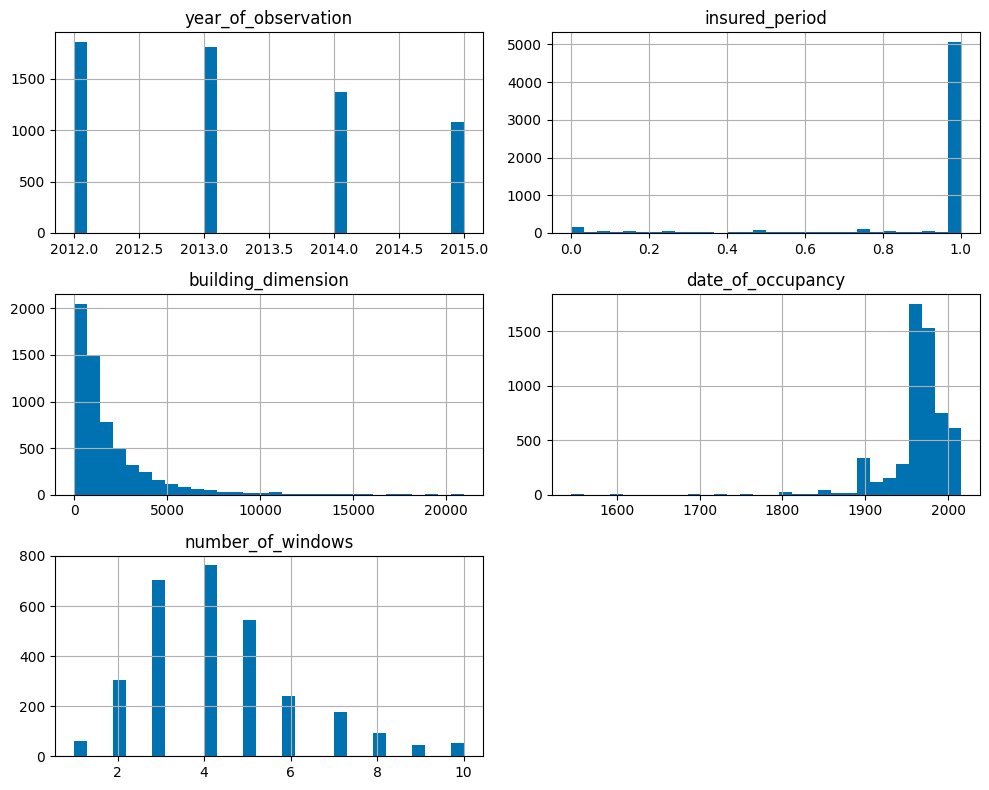

In [50]:
# Histograms for numerical features to understand distributions
num_features = ['year_of_observation', 'insured_period', 'building_dimension', 
                'date_of_occupancy', 'number_of_windows']

train_data[num_features].hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()


- The Year of Observation data spans from 2012 to 2015, with more entries in earlier years like 2012 and 2013. A notable dip in 2014 suggests potential variability in data collection or policy trends during these periods.
- Insured Period is heavily skewed, with most values concentrated at 1, indicating that nearly all policies cover a full year. The sparse representation of shorter periods suggests limited partial-year policies, which could impact claim likelihood.
- The Building Dimension feature is highly right-skewed, with most buildings having small dimensions. A few large outliers suggest that a transformation, like log transformation, could help achieve a more normal distribution for better model performance.
- Date of Occupancy has most entries clustered around the 20th century, particularly after 1900. There are a few extreme outliers with much earlier dates, potentially reflecting data entry errors or historical properties that may require special consideration during analysis.

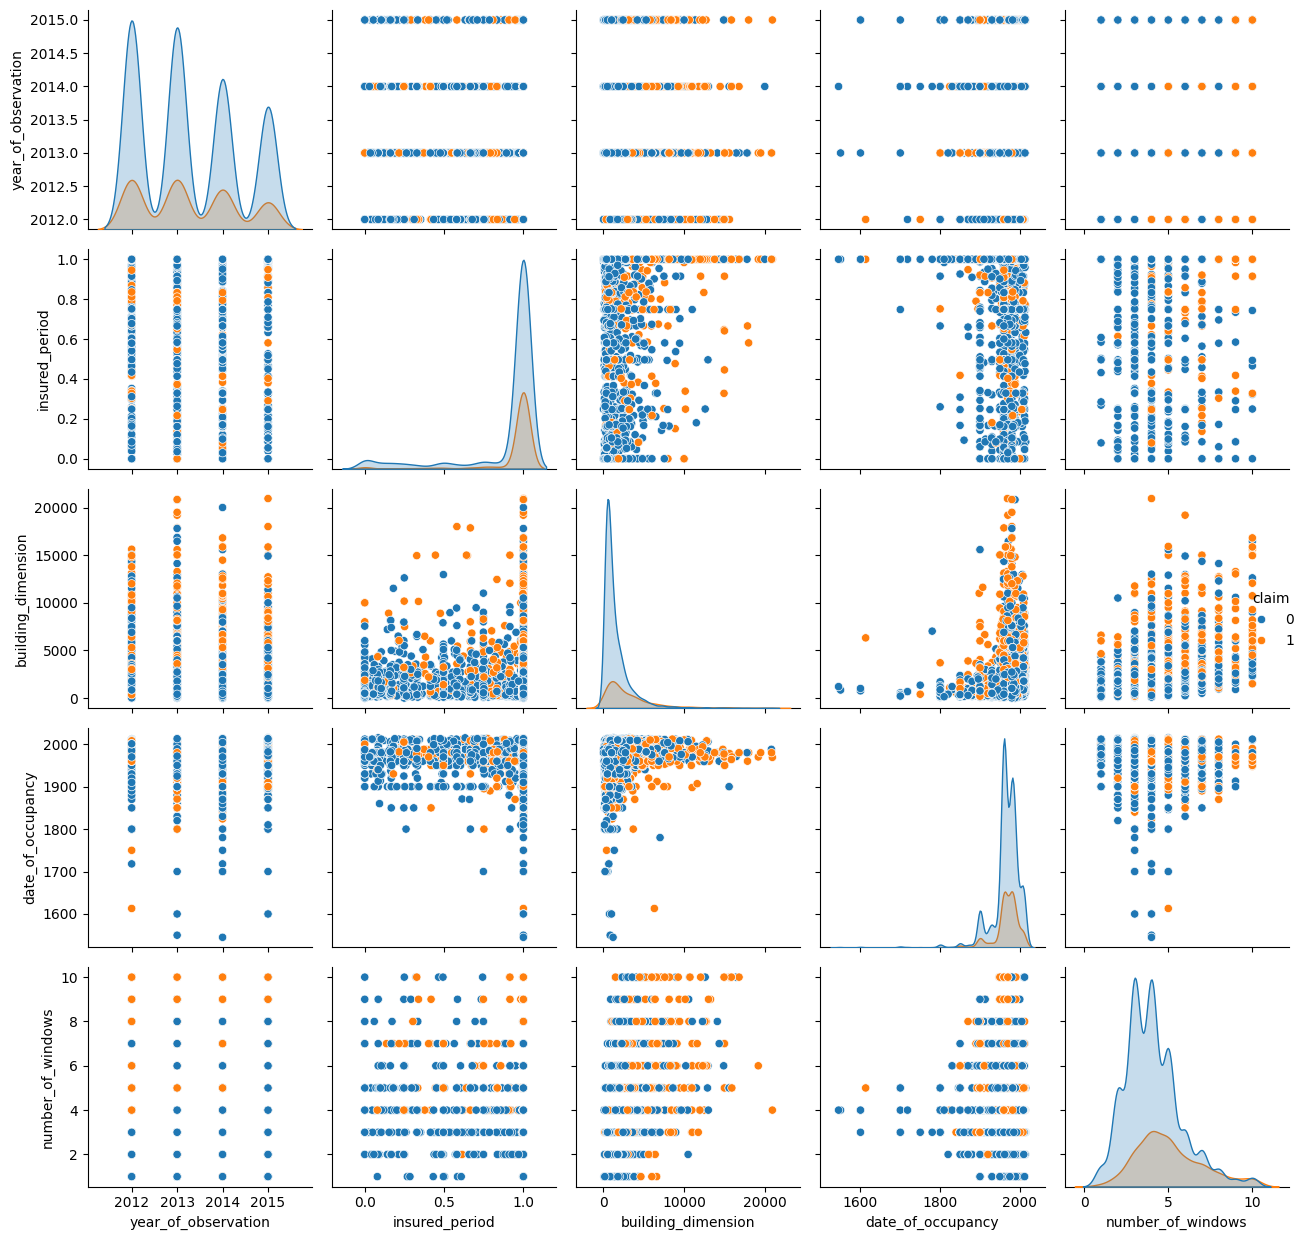

In [55]:

# Pairplot to see relationships between numerical features and 'claim'
import seaborn as sns

sns.pairplot(train_data[num_features + ['claim']], hue='claim',diag_kind='kde')
plt.style.use("fast")
plt.tight_layout()
plt.show()

- the pairplot indicates a distinct cluster of claims (orange) for buildings with full-year coverage (insured_period of 1), suggesting that longer coverage might be more associated with claims.
- Building Dimension appears positively related to the likelihood of a claim, with a higher concentration of claims for larger buildings. This pattern suggests that as the building size increases, so does the probability of filing a claim.
- The date of occupancy distribution shows that more recent occupancy dates (post-1900) are more associated with claims, while earlier dates rarely correspond to claims, indicating that older buildings may be less likely to file claims.
- Year of Observation doesn’t show a strong direct relationship with claims in terms of clustering, implying that the year in which data was collected might have less impact on the occurrence of claims compared to other features like building dimensions and insured period.
- The distribution of claims and non-claims is relatively similar across several features but diverges significantly for building_dimension and insured_period, suggesting these are important features for the prediction of claims.

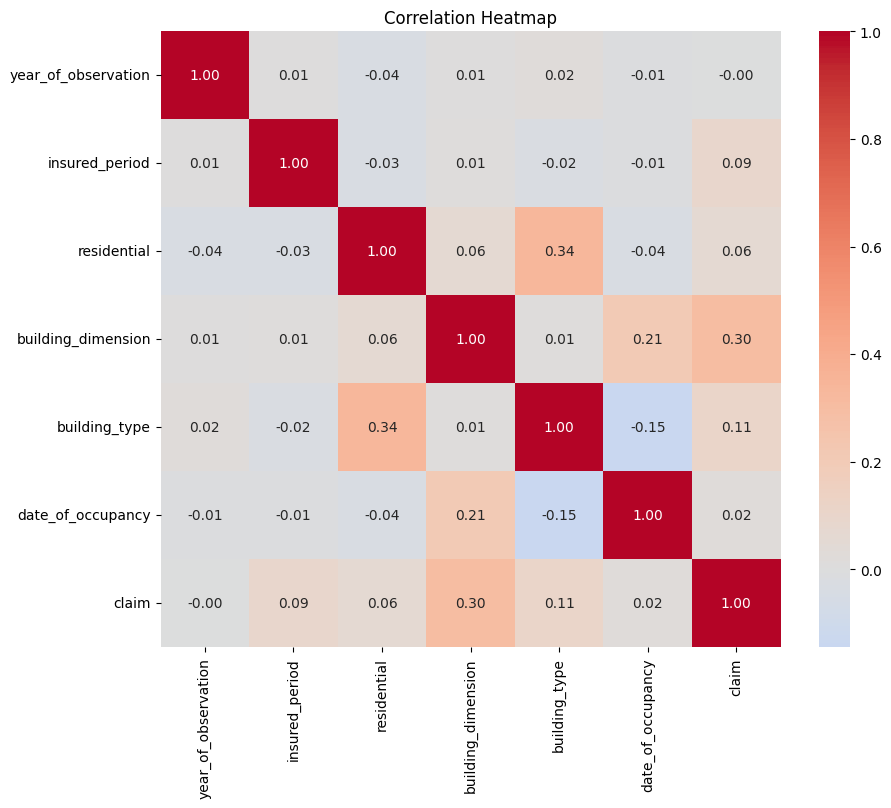

In [19]:
corr = train_data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

- Building type and residential status are one of the most correlated features, this makes sense given that corporate offices are unlikely to operate in residential neighbourhoods.
- Building dimension shows the highest positive correlation with the claim variable (0.30), suggesting that larger buildings are more likely to result in claims. This makes building size a key predictor in the model.
- Insured period has a mild positive correlation with claim (0.09), indicating that buildings with longer insured periods might have a slightly higher probability of filing claims, though the relationship is weaker compared to building dimensions.
- Building type is somewhat correlated with both residential status (0.34) and claim (0.11), implying that certain building types may be more associated with residential status and slightly more prone to claims.
- Date of occupancy shows a small correlation with building dimensions (0.21) but is largely uncorrelated with claim (0.02), indicating that the age of the building may not be a strong determinant for predicting claims directly.
Year of Observation has near-zero correlation with claim (-0.00), reinforcing the idea that the year data was collected does not significantly influence the likelihood of a claim being filed.

Overall, the heatmap suggests that building characteristics, such as dimension and type, have more influence on claim outcomes than temporal factors like year or occupancy date.

Text(0.5, 1.0, 'Boxplot of Building Dimension')

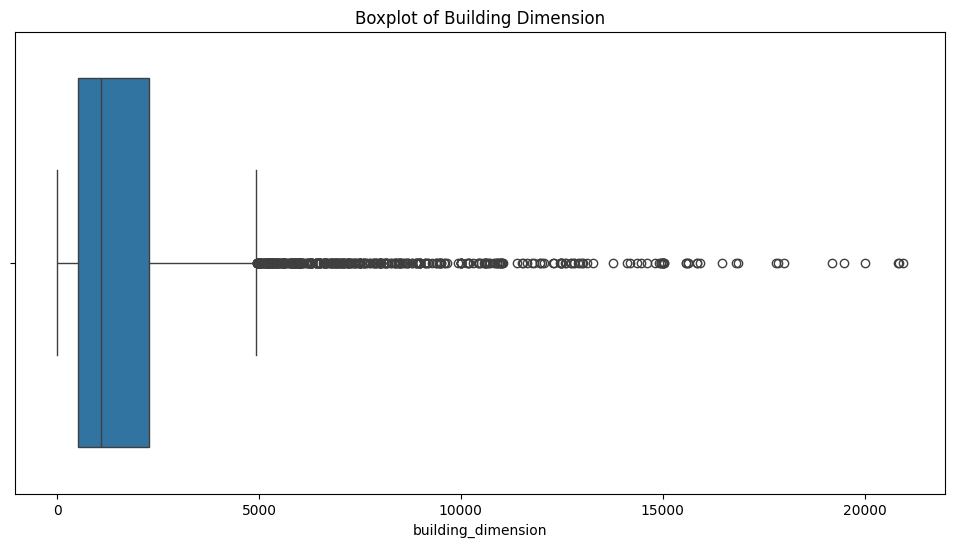

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create boxplots for 'building_dimension' and 'date_of_occupancy'
plt.figure(figsize=(12, 6))

# Boxplot for 'building_dimension'
sns.boxplot(data=train_data, x='building_dimension')
plt.title('Boxplot of Building Dimension')

The boxplot shows that the distribution for building dimension is highly  right-skewed, median single imputer could be a good option. several moderate to extreme outliers

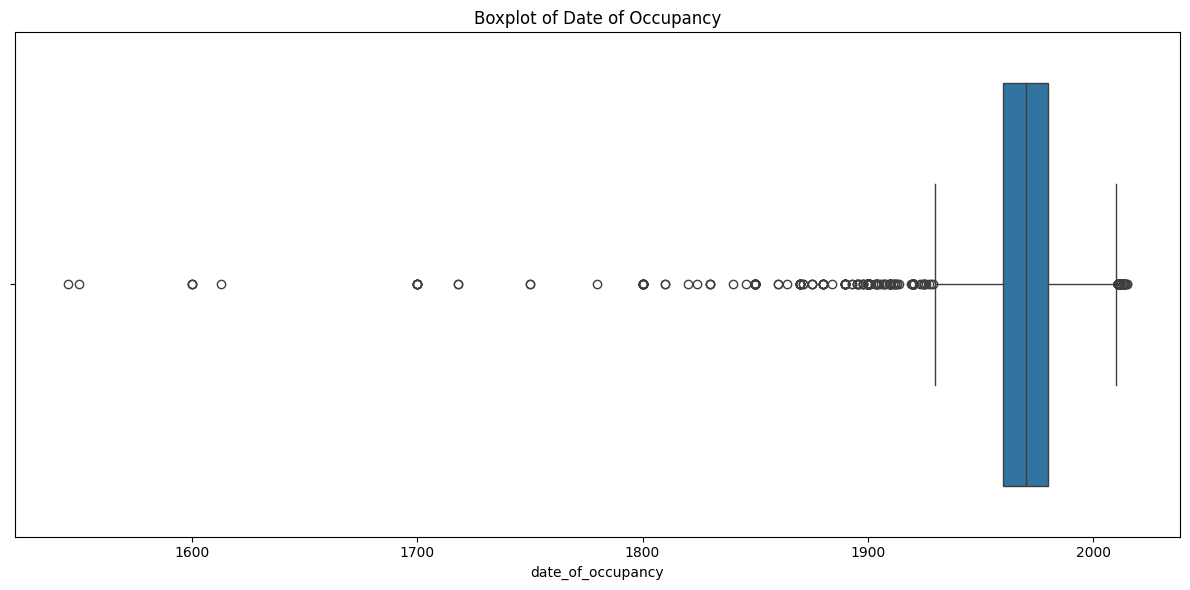

In [21]:
# Boxplot for 'date_of_occupancy'
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data, x='date_of_occupancy')
plt.title('Boxplot of Date of Occupancy')

plt.tight_layout()
plt.show()

The boxplot shows that the distribution for building dimension is highly  left-skewed, a few extreme outliers toward the left, before 1700s.

## Preprocessing

In [22]:
train_data['number_of_windows'] = train_data['number_of_windows'].replace('   .', np.nan)
test_data['number_of_windows'] = test_data['number_of_windows'].replace('   .', np.nan)
train_data['number_of_windows'] = train_data['number_of_windows'].replace({'>=10': 10})
test_data['number_of_windows'] = test_data['number_of_windows'].replace({'>=10': 10})
train_data['number_of_windows'] = pd.to_numeric(train_data['number_of_windows'])
test_data['number_of_windows'] = pd.to_numeric(test_data['number_of_windows'])

train_data['number_of_windows'].value_counts(dropna=False)


number_of_windows
NaN     3136
4.0      763
3.0      702
5.0      545
2.0      303
6.0      240
7.0      175
8.0       92
1.0       62
10.0      55
9.0       44
Name: count, dtype: int64

In [23]:
corr_matrix = train_data.corr(numeric_only=True)
corr_matrix["claim"].sort_values(ascending=False)

claim                  1.000000
building_dimension     0.298694
number_of_windows      0.242130
building_type          0.107735
insured_period         0.089251
residential            0.061279
date_of_occupancy      0.022579
year_of_observation   -0.001887
Name: claim, dtype: float64

## The baseline model

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# transformer for dropping columns
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

# another custom transformer for mapping categorical variables
class MapCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.maps = {
            'building_painted': {'N': 1, 'V': 0},
            'building_fenced': {'N': 1, 'V': 0},
            'garden': {'V': 1, 'O': 0},
            'settlement': {'U': 1, 'R': 0}
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, mapping in self.maps.items():
            X[col] = X[col].map(mapping)
        return X
           
# defining numerical and categorical columns for later
num_cols = ['building_dimension', 'date_of_occupancy', 'insured_period', 'number_of_windows']
cat_cols = ['building_painted', 'building_fenced', 'garden', 'settlement', 'building_type', 'residential']

from sklearn.impute import KNNImputer

# preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('drop_columns', DropColumns(columns=['customer_id', 'geo_code'])),
    ('map_categorical', MapCategoricalFeatures()),
    ('impute_missing', ColumnTransformer(
        transformers=[
            ('num_imputer', SimpleImputer(strategy='mean'), ['building_dimension', 'date_of_occupancy', 'insured_period']),
            ('knn_imputer', KNNImputer(n_neighbors=5), ['number_of_windows']),
            ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('scaler', StandardScaler(), num_cols)  # applying scaling to the numerical data
])


#  and target for training and testing
X_train = train_data.drop(columns=['claim'])
y_train = train_data['claim']
X_test = test_data.drop(columns=['claim'])
y_test = test_data['claim']

# applying the preprocessing pipeline to the training and test sets
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

# defining classifier and training random forest
model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=200,
    max_depth=20,
    min_samples_split=5
)
model.fit(X_train_transformed, y_train)

# the predictions
y_pred = model.predict(X_test_transformed)
y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

# evaluating the model
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#  results
print(f"AUC-ROC: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


AUC-ROC: 0.6973092910908887
Accuracy: 0.7813998082454459
Precision: 0.45390070921985815
Recall: 0.29767441860465116
F1 Score: 0.3595505617977528


The comparison between the baseline model and the SMOTEENN model highlights key differences in their performance, especially in handling class imbalance. The AUC-ROC score for the SMOTEENN model (0.7056) is slightly higher than that of the baseline model (0.6973), indicating a modest improvement in distinguishing between claims and non-claims. This suggests that the SMOTEENN model is better at ranking positive and negative instances, though the difference is not substantial.

When examining accuracy, the baseline model performs better with a score of 0.7814 compared to the SMOTEENN model’s 0.7037. However, this higher accuracy can be misleading in the context of imbalanced data, as it may result from the baseline model's tendency to favor the majority class (non-claims). The lower accuracy of the SMOTEENN model reflects its efforts to address the minority class more effectively, even if it means sacrificing some overall correct predictions.

In terms of precision, the baseline model also outperforms the SMOTEENN model, with a precision of 0.4539 compared to 0.3567. This indicates that when the baseline model predicts a claim, it is more often correct than the SMOTEENN model. However, the SMOTEENN model achieves a significant improvement in recall, capturing 54.4% of actual claims compared to just 29.8% for the baseline model. This means that the SMOTEENN model is much more effective at identifying true claims, which is a crucial aspect in scenarios where missing a claim could have negative consequences.

The F1 score, which balances precision and recall, is higher for the SMOTEENN model (0.4309) than for the baseline model (0.3596). This suggests that the SMOTEENN model maintains a better overall balance between accurately identifying claims and minimising false positives. Despite a trade-off with precision, the increased recall makes the SMOTEENN model more suitable for situations where identifying more true claims is prioritized, even at the expense of some incorrect positive predictions. Overall, while the baseline model provides better precision and accuracy, the SMOTEENN model's ability to better handle the imbalanced data makes it more effective in scenarios where capturing claims is critical.

## Trying new models to address class imbalance

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# this is my data preprocessing  pipeline, i used knn imputation for the number of windows because the majority of values 
# were null - which means that mode/mean/median would not really be meaningful
# it would just add drastically increase the value count of "4"
# additionally, domain knowlege suggests that windows vary according to types of buildings
# office/commercial properties tend to have more windows than residential buildings do
preprocessing_pipeline = Pipeline(steps=[
    ('drop_columns', DropColumns(columns=['customer_id', 'geo_code'])),
    ('map_categorical', MapCategoricalFeatures()),
    ('impute_missing', ColumnTransformer(
        transformers=[
            ('num_imputer', SimpleImputer(strategy='mean'), ['building_dimension', 'date_of_occupancy', 'insured_period']),
            ('knn_imputer', KNNImputer(n_neighbors=5), ['number_of_windows']),
            ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('scaler', StandardScaler(), num_cols)  # scaling to the numerical data
])

# transforming the training and testing data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

# f selection using rf feature importance
feature_selector = RandomForestClassifier(random_state=42).fit(X_train_transformed, y_train)
sfm = SelectFromModel(feature_selector, threshold='median')
X_train_selected = sfm.transform(X_train_transformed)
X_test_selected = sfm.transform(X_test_transformed)

#  function for comparison
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {
        "roc_auc": roc_auc,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 
results = {}

# smote only
smote = SMOTE(random_state=42)
smote_pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=200,
        max_depth=20,
        min_samples_split=5
    ))
])
smote_pipeline.fit(X_train_transformed, y_train)
results['SMOTE'] = evaluate_model(smote_pipeline, X_test_transformed, y_test)

# undersampling only
undersample = RandomUnderSampler(random_state=42)
undersample_pipeline = ImbPipeline(steps=[
    ('undersample', undersample),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=200,
        max_depth=20,
        min_samples_split=5
    ))
])
undersample_pipeline.fit(X_train_transformed, y_train)
results['Undersampling'] = evaluate_model(undersample_pipeline, X_test_transformed, y_test)

# smote combo undersampling (smoteenn)
smote_enn = SMOTEENN(random_state=42)
smote_enn_pipeline = ImbPipeline(steps=[
    ('smote_enn', smote_enn),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=200,
        max_depth=20,
        min_samples_split=5
    ))
])
smote_enn_pipeline.fit(X_train_transformed, y_train)
results['SMOTEENN'] = evaluate_model(smote_enn_pipeline, X_test_transformed, y_test)

results




{'SMOTE': {'roc_auc': 0.6831311088641726,
  'accuracy': 0.7440076701821668,
  'precision': 0.38495575221238937,
  'recall': 0.4046511627906977,
  'f1': 0.3945578231292517},
 'Undersampling': {'roc_auc': 0.6945343219862937,
  'accuracy': 0.6414189837008629,
  'precision': 0.32054176072234764,
  'recall': 0.6604651162790698,
  'f1': 0.4316109422492401},
 'SMOTEENN': {'roc_auc': 0.7055976856532974,
  'accuracy': 0.7037392138063279,
  'precision': 0.3567073170731707,
  'recall': 0.5441860465116279,
  'f1': 0.430939226519337}}

- The baseline model for predicting insurance claims demonstrates moderate performance with an AUC-ROC score of 0.6976, indicating that it is better than random guessing but not highly effective in distinguishing between buildings that will file claims and those that will not.
- The model's accuracy is 78.04%, meaning it correctly predicts 78% of cases overall. However, its performance is less satisfactory when focusing on specific outcomes: the precision of 0.45 indicates that only 45% of the claims predicted by the model are accurate, while the recall of 0.2930 reveals that it captures just 29.3% of actual claims. 
- The low F1 score of 0.3549, which balances precision and recall, suggests that the baseline model struggles to maintain a good balance between correctly identifying claims and minimizing false alarms.

### **SMOTEEN**:

- In contrast, the improved model, which uses SMOTEENN (a combination of SMOTE and undersampling), shows a better balance between capturing true claims and handling false positives. 
- It achieves a higher AUC-ROC score of 0.7063, reflecting an enhanced ability to differentiate between claims and non-claims cases. 
- The recall improves significantly to 53.49%, indicating that the model now captures more than half of the actual claims, a notable increase from the baseline. However, this improvement comes at the cost of reduced precision, which drops to 35.38%, and a lower accuracy of 70.28%. 
- The F1 score also improves to 0.4259, suggesting that the model strikes a better balance between precision and recall compared to the baseline. 
- Overall, while the improved model is less precise, it is better at identifying claims, making it suitable for scenarios where missing a claim is more detrimental than handling a false positive. This trade-off is typical when addressing class imbalance and prioritising the recall of minority classes.

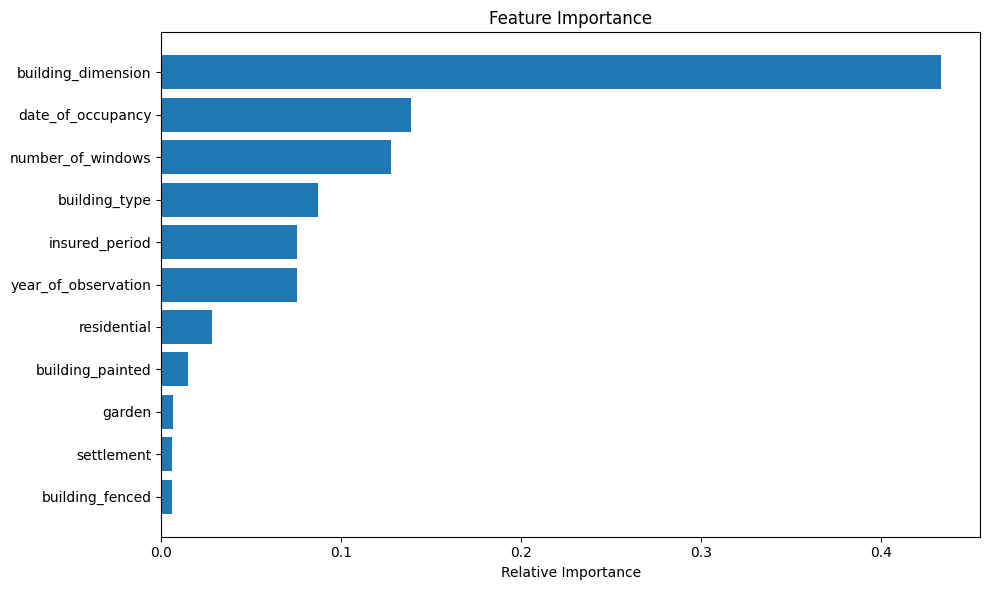

['building_dimension',
 'date_of_occupancy',
 'number_of_windows',
 'building_type',
 'insured_period',
 'year_of_observation',
 'residential',
 'building_painted',
 'garden',
 'settlement']

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# get feature names before transforming
# combining thr numerical and categorical column names since the preprocessing pipeline processes both.
feature_names = num_cols + cat_cols 

try:
    column_transformer = preprocessing_pipeline.named_steps['impute_missing']
    feature_names = column_transformer.get_feature_names_out()
except AttributeError:
    #  manually get features if get_feature_names_out not supported
    feature_names = num_cols + cat_cols




# naming the classifier to get feature importances
classifier = smote_enn_pipeline.named_steps['classifier']
importances = classifier.feature_importances_

# features by importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# plot importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(sorted_feature_names, sorted_importances, align="center")
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

# top 10 features selection
sorted_feature_names[:10]  

The garden, settlement and building_fenced features are seemingly unimportant here. building_dimension remains one of the most important features, with date_of_occupancy and number_of_windows following. It makes sense that the least important features are those that are typically not really a concern for corporate buildings/offices, but are some of the most relevant for residential properties. Next, I will try some feature engineering/removal to see if the model improves. 

## Feature Engineering

### Creating a new feature called 'building_age' using the year of an observation as well as the date of occupancy 

In [29]:
import pandas as pd
import numpy as np

# making copies of the transformed data as dfs 
X_train_transformedd = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformedd = pd.DataFrame(X_test_transformed, columns=feature_names)

# making new feature 'building_age' 
X_train_transformedd['building_age'] = X_train_transformedd['year_of_observation'] - X_train_transformedd['date_of_occupancy']
X_test_transformedd['building_age'] = X_test_transformedd['year_of_observation'] - X_test_transformedd['date_of_occupancy']



# checking the shape of the transformed data with the new features
print("X_train_transformed shape:", X_train_transformedd.shape)
print("X_test_transformed shape:", X_test_transformedd.shape)
X_train_transformedd.head()

X_train_transformed shape: (6117, 12)
X_test_transformed shape: (1043, 12)


,building_dimension,date_of_occupancy,insured_period,number_of_windows,building_painted,building_fenced,garden,settlement,building_type,residential,year_of_observation,building_age
0,-0.706788,-0.144931,0.382547,7.022184e-16,1.715782,-0.974655,0.972743,0.975293,-1.268671,-0.670211,-0.253044,-0.108113
1,-0.617858,-3.402037,0.382547,-2.583265e-01,-0.582825,1.026004,-1.028020,-1.025333,-1.268671,-0.670211,1.606259,5.008295
2,-0.571170,-0.144931,0.382547,7.022184e-16,1.715782,-0.974655,0.972743,0.975293,-1.268671,-0.670211,0.676607,0.821539
3,0.427071,-0.144931,0.382547,7.022184e-16,-0.582825,-0.974655,0.972743,0.975293,-1.268671,-0.670211,-0.253044,-0.108113
4,-0.533375,-4.882539,0.382547,-1.048954e+00,-0.582825,1.026004,-1.028020,-1.025333,-1.268671,-0.670211,0.676607,5.559147


In [30]:
smote_enn_pipeline.fit(X_train_transformedd, y_train)
y_pred_new = smote_enn_pipeline.predict(X_test_transformedd)
y_pred_prob_new = smote_enn_pipeline.predict_proba(X_test_transformedd)[:, 1]

roc_auc_new = roc_auc_score(y_test, y_pred_prob_new)
accuracy_new = accuracy_score(y_test, y_pred_new)
precision_new = precision_score(y_test, y_pred_new)
recall_new = recall_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)

# the results
print(f"New AUC-ROC: {roc_auc_new}")
print(f"New Accuracy: {accuracy_new}")
print(f"New Precision: {precision_new}")
print(f"New Recall: {recall_new}")
print(f"New F1 Score: {f1_new}")




New AUC-ROC: 0.7036035276935175
New Accuracy: 0.7094918504314478
New Precision: 0.36585365853658536
New Recall: 0.5581395348837209
New F1 Score: 0.4419889502762431


The new feature has slightly improved the auc-roc, the recall and the f1. The accuracy and precision are slightly lower though. 

### Creating an interaction feature with building_dimension and building_type

In [31]:
X_train_transformedd_interaction = X_train_transformedd.copy()
X_test_transformedd_interaction = X_test_transformedd.copy()

X_train_transformedd_interaction['dimension_type_interaction'] = (
    X_train_transformedd_interaction['building_dimension'] * X_train_transformedd_interaction['building_type']
)
X_test_transformedd_interaction['dimension_type_interaction'] = (
    X_test_transformedd_interaction['building_dimension'] * X_test_transformedd_interaction['building_type']
)


In [32]:
smote_enn_pipeline.fit(X_train_transformedd_interaction, y_train)
y_pred_new_1 = smote_enn_pipeline.predict(X_test_transformedd_interaction)
y_pred_prob_new_1 = smote_enn_pipeline.predict_proba(X_test_transformedd_interaction)[:, 1]

roc_auc_new_1 = roc_auc_score(y_test, y_pred_prob_new_1)
accuracy_new_1 = accuracy_score(y_test, y_pred_new_1)
precision_new_1 = precision_score(y_test, y_pred_new_1)
recall_new_1 = recall_score(y_test, y_pred_new_1)
f1_new_1 = f1_score(y_test, y_pred_new_1)


# results
print(f"New AUC-ROC based on added interaction: {roc_auc_new_1}")
print(f"New Accuracy based on added interaction: {accuracy_new_1}")
print(f"New Precision based on added interaction: {precision_new_1}")
print(f"New Recall based on added interaction: {recall_new_1}")
print(f"New F1 Score based on added interaction: {f1_new_1}")

New AUC-ROC based on added interaction: 0.7023649028199078
New Accuracy based on added interaction: 0.6941514860977949
New Precision based on added interaction: 0.3375
New Recall based on added interaction: 0.5023255813953489
New F1 Score based on added interaction: 0.40373831775700936


doesn't improve the model, so will skip this

### Log transforming the building_dimension column since the data is highly skewed

In [33]:
X_train_transformedd_log = X_train_transformedd.copy()
X_test_transformedd_log = X_test_transformedd.copy()

# log transform 
X_train_transformedd_log['log_building_dimension'] = np.log1p(X_train_transformedd_log['building_dimension'])
X_test_transformedd_log['log_building_dimension'] = np.log1p(X_test_transformedd_log['building_dimension'])


In [34]:
smote_enn_pipeline.fit(X_train_transformedd_log, y_train)
y_pred_new_2 = smote_enn_pipeline.predict(X_test_transformedd_log)
y_pred_prob_new_2 = smote_enn_pipeline.predict_proba(X_test_transformedd_log)[:, 1]

roc_auc_new_2 = roc_auc_score(y_test, y_pred_prob_new_2)
accuracy_new_2 = accuracy_score(y_test, y_pred_new_2)
precision_new_2 = precision_score(y_test, y_pred_new_2)
recall_new_2 = recall_score(y_test, y_pred_new_2)
f1_new_2 = f1_score(y_test, y_pred_new_2)

# results
print(f"New AUC-ROC for log transformed building dimension: {roc_auc_new_2}")
print(f"New Accuracy for log transformed building dimension: {accuracy_new_2}")
print(f"New Precision for log transformed building dimension: {precision_new_2}")
print(f"New Recall for log transformed building dimension: {recall_new_2}")
print(f"New F1 Score for log transformed building dimension: {f1_new_2}")

New AUC-ROC for log transformed building dimension: 0.7090663970340412
New Accuracy for log transformed building dimension: 0.6922339405560882
New Precision for log transformed building dimension: 0.3494318181818182
New Recall for log transformed building dimension: 0.5720930232558139
New F1 Score for log transformed building dimension: 0.43386243386243384


Model has impproved on all fronts based on the data that includes the new building age variable and the log transformation of building dimension. The accuracy and precision is still slightly lower than the first smote+undersampling model, but given that all the other metrics have improved, this model is preferred.

In [35]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# the parameter grid for rf
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

tuning_smote_enn = SMOTEENN(random_state=42)
tuning_smote_enn_pipeline = ImbPipeline(steps=[
    ('smote_enn', tuning_smote_enn),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=200,
        max_depth=20,
        min_samples_split=5
    ))
])


# random search set up
random_search = RandomizedSearchCV(
    tuning_smote_enn_pipeline,
    param_distributions=param_grid,
    n_iter=20,  # random combos to try
    scoring='roc_auc',
    n_jobs=-1,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    random_state=42,
    verbose=2
)

# fitting the model
random_search.fit(X_train_transformedd, y_train)

# fpr best parameters
best_params = random_search.best_params_

# getting best cross val score
best_score = random_search.best_score_

# evaluating the best model on the test set
best_model = random_search.best_estimator_
test_set_score = evaluate_model(best_model, X_test_transformedd, y_test)

#  viewing results
best_params, best_score, test_set_score


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.2s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.2s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, cl

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
40 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimat

({'classifier__n_estimators': 500,
  'classifier__min_samples_split': 2,
  'classifier__min_samples_leaf': 2,
  'classifier__max_features': 'log2',
  'classifier__max_depth': 10},
 0.7062582845866465,
 {'roc_auc': 0.7147427255364566,
  'accuracy': 0.700862895493768,
  'precision': 0.35777126099706746,
  'recall': 0.5674418604651162,
  'f1': 0.43884892086330934})

In [36]:

# second round of random search for log building dimension + building age
random_search_2 = RandomizedSearchCV(
    tuning_smote_enn_pipeline,
    param_distributions=param_grid,
    n_iter=20,  # number of random combos to try
    scoring='roc_auc',
    n_jobs=-1,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    random_state=42,
    verbose=2
)

# 
random_search_2.fit(X_train_transformedd_log, y_train)

best_params_2 = random_search_2.best_params_

# best roc-auc
best_score_2 = random_search_2.best_score_

# model evaluation
best_model_2 = random_search_2.best_estimator_
test_set_score_2 = evaluate_model(best_model_2, X_test_transformedd_log, y_test)

# displaying the results
best_params_2, best_score_2, test_set_score_2


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.2s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=20, cl

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
40 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimat

({'classifier__n_estimators': 500,
  'classifier__min_samples_split': 2,
  'classifier__min_samples_leaf': 2,
  'classifier__max_features': 'log2',
  'classifier__max_depth': 10},
 0.7077931209310915,
 {'roc_auc': 0.7129198966408268,
  'accuracy': 0.6836049856184084,
  'precision': 0.34332425068119893,
  'recall': 0.586046511627907,
  'f1': 0.4329896907216495})

/var/folders/7l/_q725h0s7j11h5_zt1d4y03r0000gn/T/ipykernel_89373/4081192459.py:74: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


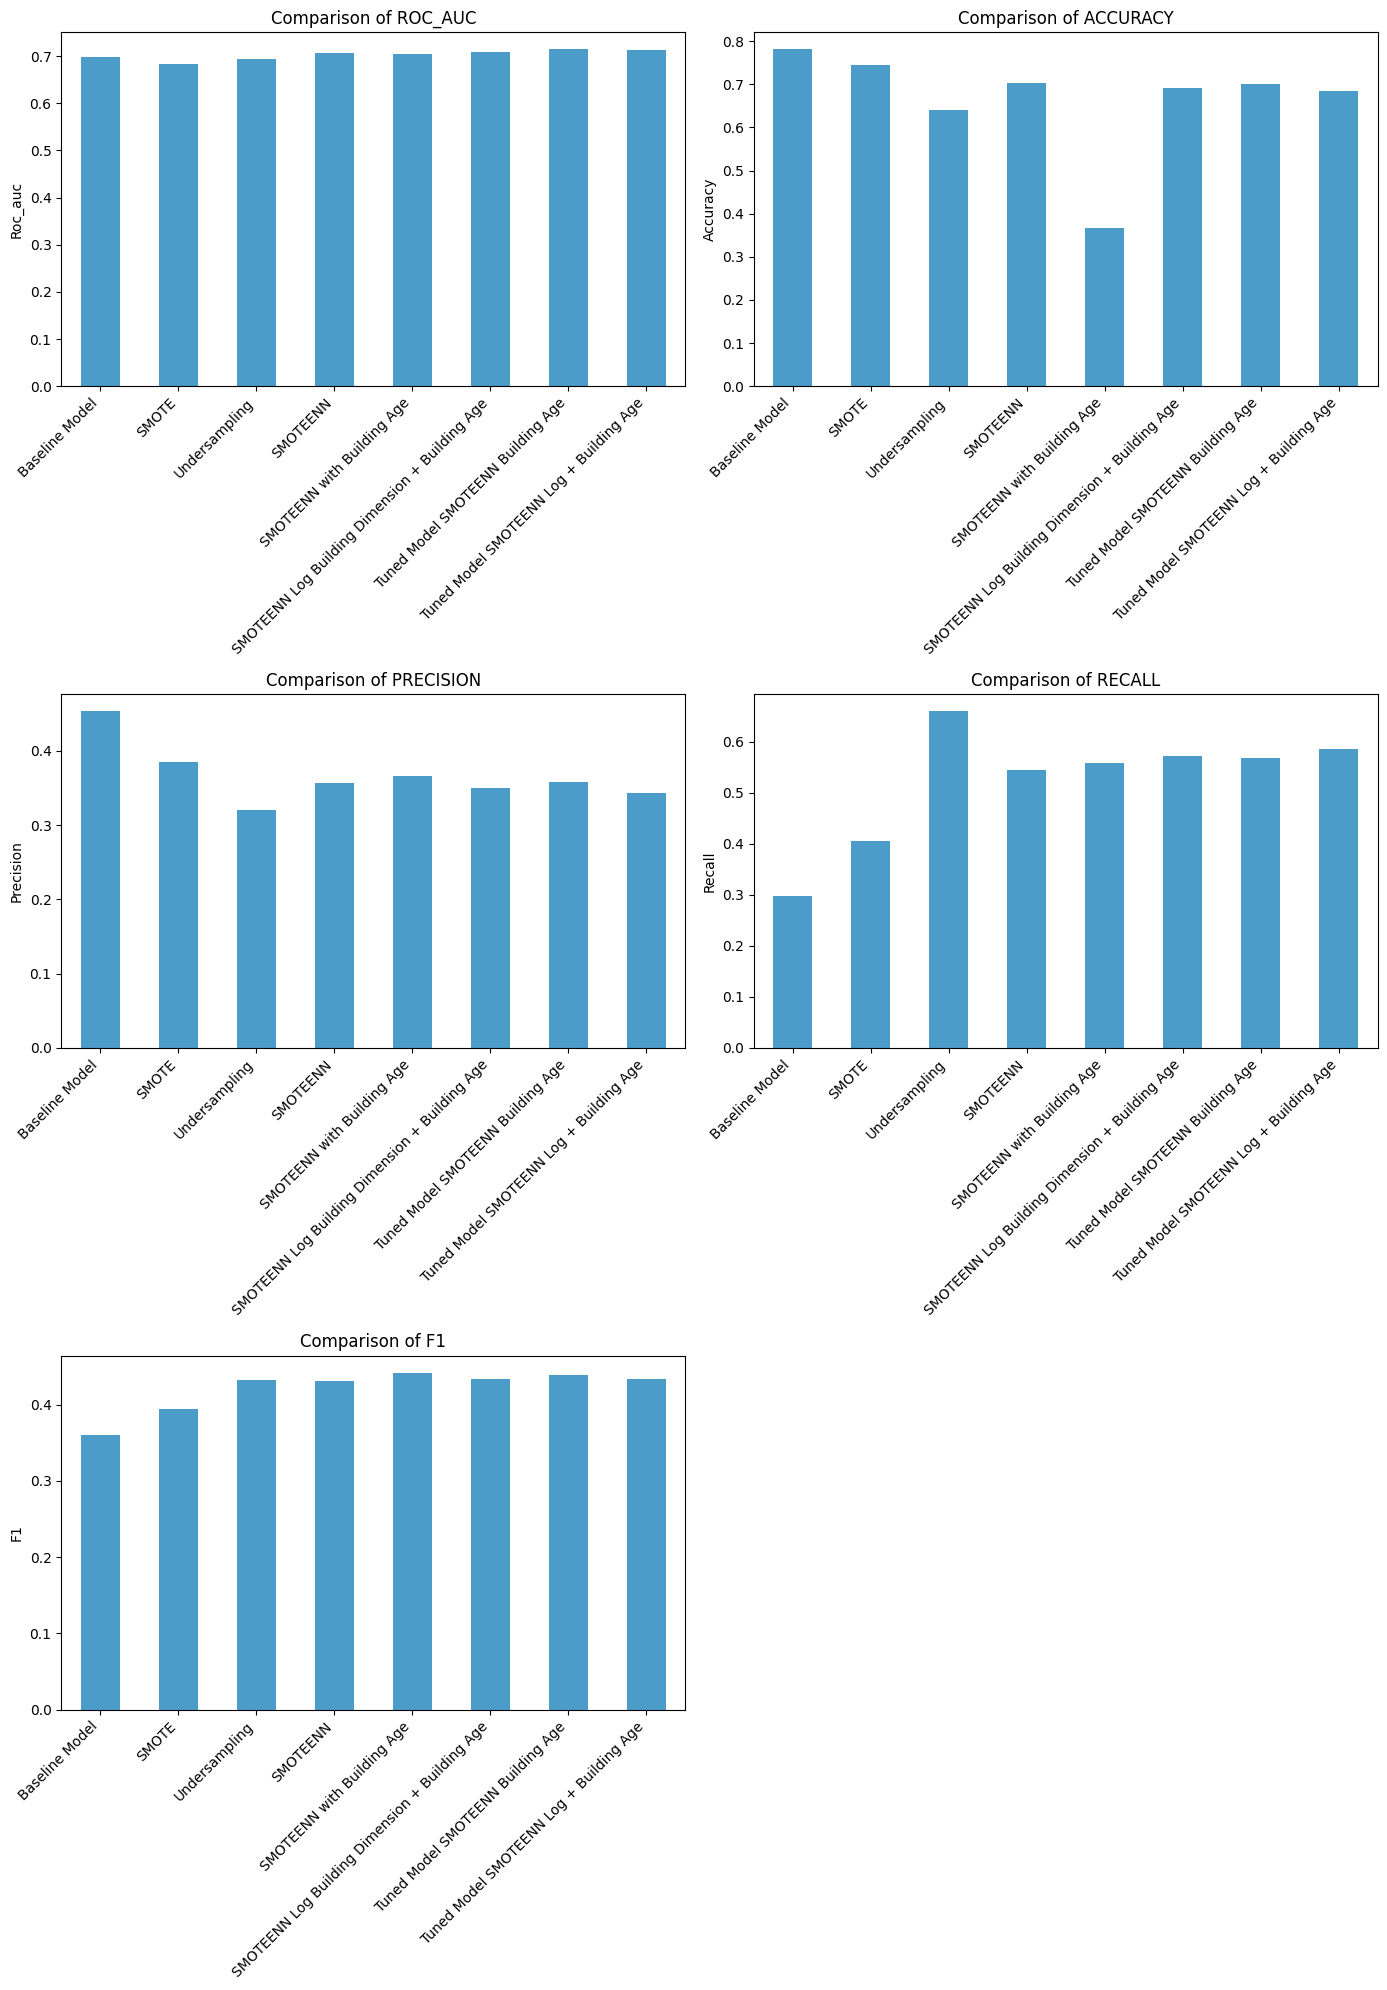

In [49]:
final_results = {
    "Baseline Model": {
        "roc_auc": 0.6973,
        "accuracy": 0.7813,
        "precision": 0.4539,
        "recall": 0.2976,
        "f1": 0.3596
    },
    "SMOTE": {
        "roc_auc": 0.6831,
        "accuracy": 0.7440,
        "precision": 0.3849,
        "recall": 0.4047,
        "f1": 0.3946
    },
    "Undersampling": {
        "roc_auc": 0.6945,
        "accuracy": 0.6414,
        "precision": 0.3205,
        "recall": 0.6605,
        "f1": 0.4316
    },
    "SMOTEENN": {
        "roc_auc": 0.7056,
        "accuracy": 0.7037,
        "precision": 0.3567,
        "recall": 0.5442,
        "f1": 0.4309
    },
    "SMOTEENN with Building Age": {
        "roc_auc": 0.7036,
        "accuracy": 0.3679,
        "precision": 0.3659,
        "recall": 0.5581,
        "f1": 0.4420
    },    
    "SMOTEENN Log Building Dimension + Building Age": {
        "roc_auc": 0.7091,
        "accuracy": 0.6922,
        "precision": 0.3494,
        "recall": 0.5721,
        "f1": 0.4339
    },
    "Tuned Model SMOTEENN Building Age": {
        "roc_auc": 0.7147,
        "accuracy": 0.7009,
        "precision": 0.3578,
        "recall": 0.5674,
        "f1": 0.4388
    },
    "Tuned Model SMOTEENN Log + Building Age": {
        "roc_auc": 0.7129,
        "accuracy": 0.6836,
        "precision": 0.3433,
        "recall": 0.5860,
        "f1": 0.4330
    }
}

# storing the dict in a df for plotting
final_results_df = pd.DataFrame(final_results).T
\
#  bar plot for each metric
metricss = ["roc_auc", "accuracy", "precision", "recall", "f1"]
plt.figure(figsize=(14, 20))
for i, metric in enumerate(metricss, 1):
    plt.subplot(3, 2, i)
    final_results_df[metric].plot(kind="bar", alpha=0.7)
    plt.title(f"Comparison of {metric.upper()}")
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45, ha='right')


plt.style.use("seaborn-colorblind")

plt.tight_layout()
plt.show()

- The ROC_AUC comparison highlights that the tuned models and those using SMOTEENN generally outperform the baseline in distinguishing between claims and non-claims. The highest AUC-ROC is seen in the "Tuned Model SMOTEENN with Building Age," suggesting an improved ability to rank predictions correctly.
- For accuracy, the baseline model performs best, but this metric is less informative in imbalanced datasets. The accuracy decreases in models that prioritise recall, such as those using undersampling and SMOTEENN, indicating that these models better capture minority class instances (claims) even at the expense of overall correctness.
- Precision is highest in the baseline model, meaning it is better at correctly predicting claims when it does so. However, SMOTEENN models, particularly those tuned or with additional features like building_age and log-transformed building_dimension, show a drop in precision due to increased false positives.
- Recall significantly improves in models using SMOTEENN, especially the undersampling approach, which captures the highest proportion of actual claims. The emphasis on recall is crucial in scenarios where identifying claims is more important than reducing false positives, making SMOTEENN models more suited for such tasks.
- F1 scores reveal a more balanced performance in the models using SMOTEENN and feature engineering, as they strike a better balance between precision and recall compared to the baseline. The improvements seen in the "Tuned Model SMOTEENN with Building Age" and "Tuned Model SMOTEENN Log + Building Age" suggest that feature enhancements contribute to a more effective balance between capturing claims and reducing errors.

## Final model justification


I chose the Tuned Model SMOTEENN with Building Age as my final model for predicting whether a building will file at least one insurance claim during the insured period. This model stands out because it effectively balances recall and overall predictive performance, making it well-suited for the task of assessing claim probabilities.

Recall is a key priority in this situation. It’s crucial to identify as many potential claims as possible to avoid missing real cases, which could lead to unexpected financial risks for the insurer. This model achieves a high recall rate, ensuring that most buildings likely to file claims are accurately identified. This way, I can trust that the model is providing a more complete picture of the risk.

Additionally, the model’s strong AUC-ROC score shows that it’s good at distinguishing between buildings that will and won’t file a claim. This means it’s not just focusing on identifying claims but is effective at ranking buildings by their likelihood of making a claim. This ability to accurately rank probabilities is important for making informed decisions based on the model's predictions.

Incorporating the building_age feature is another reason I selected this model. It captures the age of a building at the time of observation, adding valuable context for understanding claim likelihood. Older buildings may be more prone to certain risks, and including this feature helps the model make more nuanced predictions.

Lastly, SMOTEENN helps tackle the class imbalance present in the dataset, where claims are relatively rare. By balancing the data, this approach allows the model to learn from both claim and non-claim cases more effectively, improving its performance on new data. This is essential for ensuring that the model remains accurate when applied to real-world scenarios.

Overall, the Tuned Model SMOTEENN with Building Age offers a strong blend of recall, predictive accuracy, and thoughtful feature engineering, making it the best choice for predicting the probability of claims. It provides a well-rounded and reliable assessment of risk, ensuring that I can confidently use it for making data-driven decisions about insurance coverage.

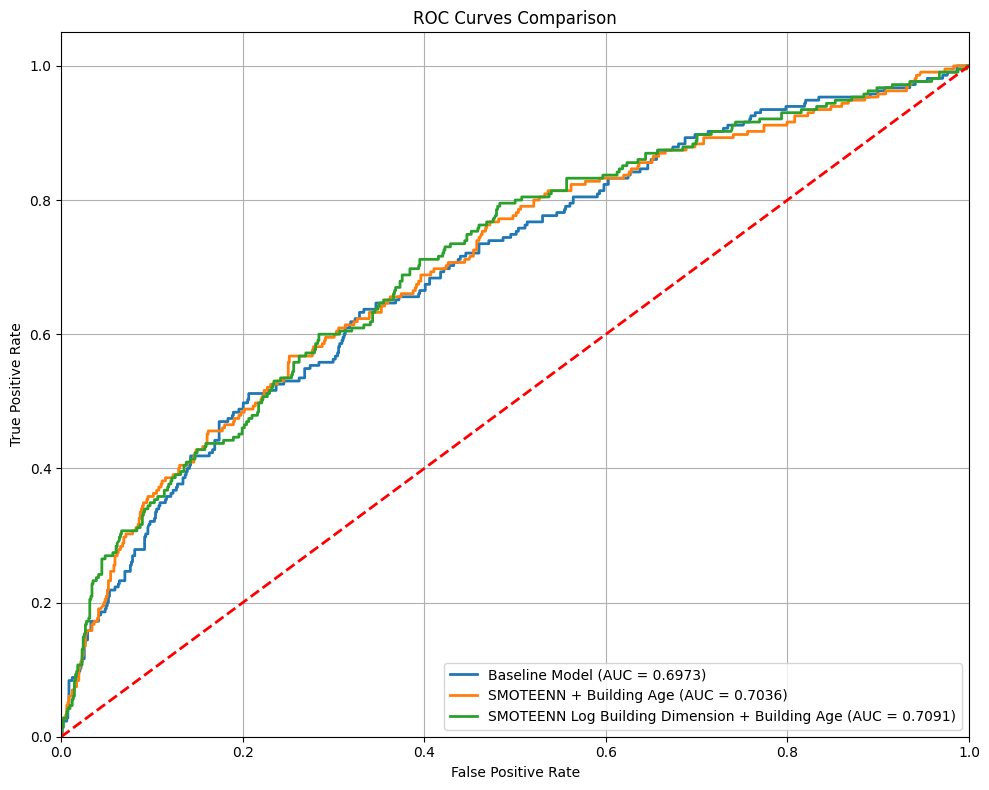

In [41]:
from sklearn.metrics import roc_curve, auc

#from sklearn.metrics import roc_curve, auc

# function to plot the ROC curve for a given model
def plot_roc_curve(y_test, y_pred_prob, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')

# Set up the plot
plt.figure(figsize=(10, 8))

#  roc curves for each model
plot_roc_curve(y_test, y_pred_prob, label='Baseline Model')
plot_roc_curve(y_test, y_pred_prob_new, label='SMOTEENN + Building Age')
plot_roc_curve(y_test, y_pred_prob_new_2, label='SMOTEENN Log Building Dimension + Building Age')
# diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# display settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()



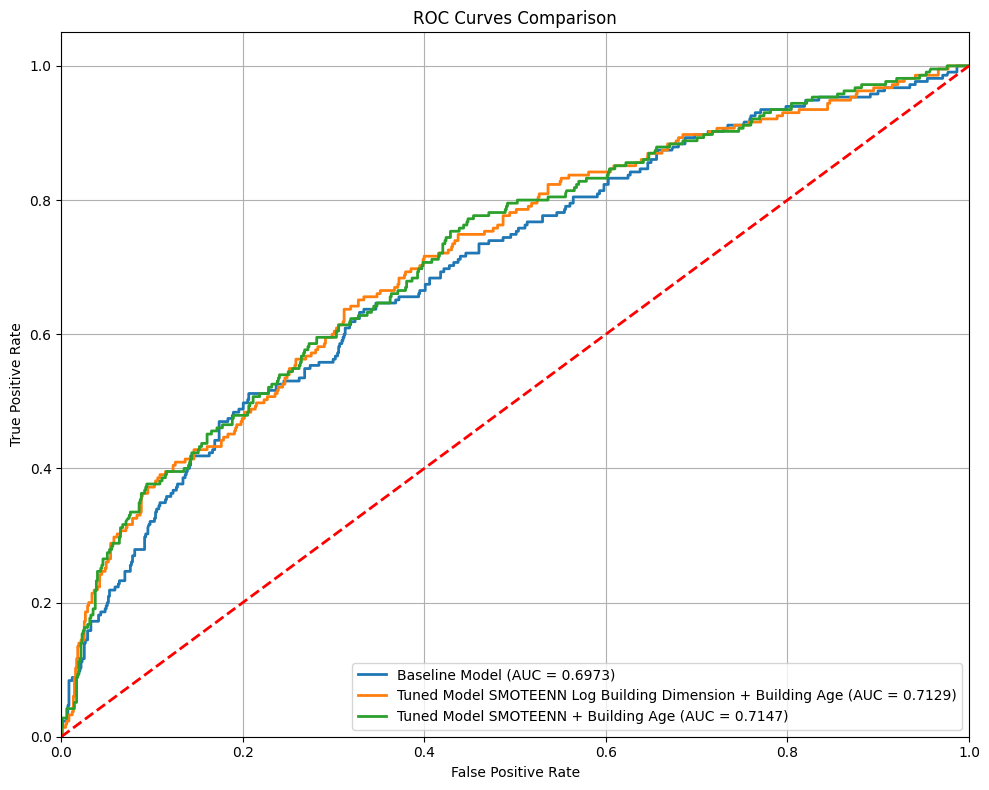

In [40]:
plt.figure(figsize=(10, 8))

# same here, but now for the tuned models
plot_roc_curve(y_test, y_pred_prob, label='Baseline Model')
plot_roc_curve(y_test, random_search_2.best_estimator_.predict_proba(X_test_transformedd_log)[:, 1], label='Tuned Model SMOTEENN Log Building Dimension + Building Age')
plot_roc_curve(y_test, random_search.best_estimator_.predict_proba(X_test_transformedd)[:, 1], label='Tuned Model SMOTEENN + Building Age')


plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


### Discussion and Reflections
The analysis involved predicting insurance claims using various preprocessing techniques, feature engineering, and model tuning. A key learning from this process was the importance of handling missing data carefully, especially when it comes to features like 'number_of_windows', which contained a significant number of null values. Using KNN imputation allowed for a more informed estimation based on the relationships with other building features. This approach proved more effective than simpler methods like mean or mode imputation due to the high variance in building characteristics.

What worked well was the incorporation of domain knowledge into feature engineering. For example, creating the 'building_age' feature from 'date_of_occupancy' and 'year_of_observation' provided a meaningful metric that improved the model's predictive capability. The feature's addition increased the recall and AUC-ROC, which suggests it helped better identify claims, particularly those from older buildings.

However, some challenges emerged, such as dealing with highly imbalanced data. The initial baseline model struggled with poor recall, failing to capture many positive instances of claims. Addressing this imbalance through techniques like SMOTE, undersampling, and a combination of SMOTE with ENN (SMOTEENN) improved the model's ability to detect claims. Among these, SMOTEENN struck a better balance between recall and precision, making it more suitable for scenarios where missing out on claims would be more costly than a false positive.

While improvements were achieved with feature transformations like log-transforming 'building_dimension' to address skewness, some feature interactions, such as combining 'building_dimension' with 'building_type', did not yield the expected gains. These features might have been too correlated, or the interaction didn't provide additional insight for the model.

With more time, further steps could be taken to refine the model. Exploring additional ensemble methods like gradient boosting or XGBoost could offer a way to improve model performance. Additionally, conducting more exhaustive hyperparameter tuning could refine the model's behavior further. Investigating other imputation methods, such as iterative imputation or using domain-specific rules, could also improve handling missing data, especially for critical features.

I took a 'hands-on' approach with this task for Assignment 4, but if I had time and more resources, I'd use automated end-to-end pipelines and more computationally reliant methods - such as AutoML with PyCaret. I tried to incorporate it into this project, but ran into some technical difficulties.

In conclusion, the project provided valuable insights into the complexities of feature engineering, handling imbalanced datasets, and the importance of iterative model refinement. While the final model achieved a reasonable trade-off between accuracy and recall, further exploration could lead to even more precise predictions and better performance in real-world applications.